In [26]:
import gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

**stochastic Bellman equation**

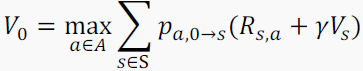

In [3]:
# using the Bellman equation, we find the action providing the highest value for the given state s. 
# V is the list of values of all states
def choose_best_action(env, V, s, gamma):
    a_best = None
    q_best = float('-inf')
    nb_actions = env.action_space.n
    for a in range (0, nb_actions):
        env.env.s = s # go to state s
        s_next, r, done, info = env.step(a) # take the action a
        q = r + gamma * V[s_next] # compute the value future value after taking action a
        if q > q_best:
            q_best = q
            a_best = a
    return a_best

**Value Iteration Algorithm**

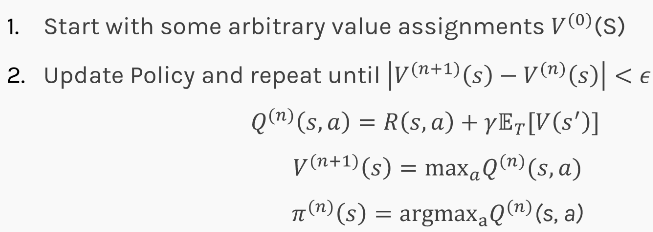

In [9]:
# value iteration algorithm
def compute_value_iteration(env = gym.make('FrozenLake-v1', is_slippery=False), 
                            gamma=.9, v_delta_threshold=.01,
                            V = None, verbose=True):
    env.reset()
    nb_actions = env.action_space.n
    nb_states = env.observation_space.n
    # values vector
    if V == None:
        V = np.zeros([nb_states])
    # policy vector
    P = np.zeros([nb_states], dtype=int)
    iteration = 0
    while True:

        v_delta = 0
        for s in range (0, nb_states):
            v_previous = V[s]
            a_best = choose_best_action(env, V, s, gamma) # find an action with the highest future reward
            env.env.s = s # go to the state s
            s_next, r, done, info = env.step(a_best) #take the best action
            V[s] = r + gamma * V[s_next] # update the value of the state
            P[s] = a_best # store the best action in the policy vector for the state
            v_delta = max(v_delta, np.abs(v_previous - V[s])) # calculate the rate of value improvment for the state
        iteration += 1
        if v_delta < v_delta_threshold:
            if verbose:
                print (iteration,' iterations done')
            break
    return V, P

# compute values for a 4x4 board 
V_4, P_4 = compute_value_iteration()
V_4

7  iterations done


array([0.59049, 0.6561 , 0.729  , 0.6561 , 0.6561 , 0.     , 0.81   ,
       0.     , 0.729  , 0.81   , 0.9    , 0.     , 0.     , 0.9    ,
       1.     , 0.     ])

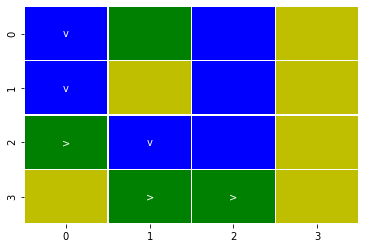

Total Reward:  1.0


In [17]:
# function for displaying a heatmap
def display_value_iteration(P, env = gym.make('FrozenLake-v1', is_slippery=False)):
    nb_states = env.observation_space.n
    visited_states = np.zeros(nb_states).astype(bool)
    visited_states[0] = 1
    states_labels = np.where(P==0, '<', 
                              np.where(P==1, '>', 
                                       np.where(P==2, 'v', 
                                                np.where(P==3, '^', P)
                                               )
                                      )
                             ) 
    desc = env.unwrapped.desc.ravel().astype(str)
    colors = np.where(desc=='S','y',np.where(desc=='F','b',np.where(desc=='H','r',np.where(desc=='G','g',desc))))
    states_labels = np.zeros(nb_states).astype(str)
    states_labels[:] = ''
    total_reward = 0
    s = env.reset()
    #env.render()
    done = False
    while done != True: 
        best_a = P[s] # select the best next action from the policy
        states_labels[s] = '^' if best_a==0 else ('v' if best_a==1 else ('>' if best_a==2 else '<'))   
        #print(s, best_a)
        s, rew, done, info = env.step(best_a) #take step using selected action
        total_reward = total_reward + rew
        visited_states[s] = 1 # mark the state as visited
        #env.render()
    ax = sns.heatmap(P.reshape(int(np.sqrt(nb_states)),int(np.sqrt(nb_states))), 
                 linewidth=0.5, 
                 annot=states_labels.reshape(int(np.sqrt(nb_states)),int(np.sqrt(nb_states))), 
                 cmap=list(colors),
                 fmt = '',
                 cbar=False)
    plt.show()
    print("Total Reward: ", total_reward)
    
# display heatmap for a 4x4 board
display_value_iteration(P_4)

15  iterations done


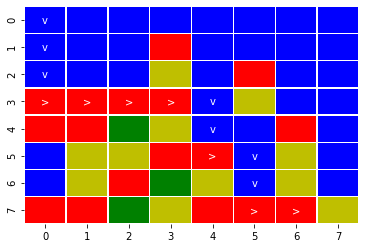

Total Reward:  1.0


In [20]:

V_8, P_8 = compute_value_iteration(env = gym.make('FrozenLake8x8-v1', is_slippery=False))
V_8
display_value_iteration(P_8, env = gym.make('FrozenLake8x8-v1', is_slippery=False))

**Policy iteration**

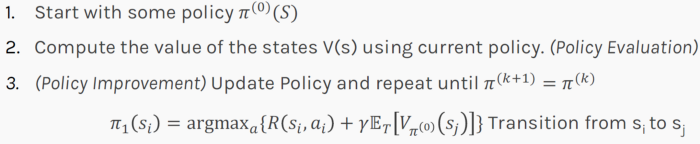

6  iterations done


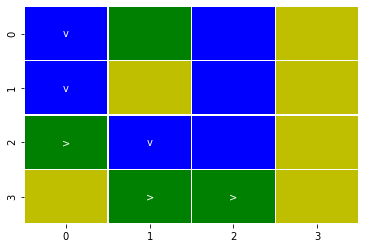

Total Reward:  1.0


In [22]:
# function for performing policy iteration
def compute_policy_iteration(env = gym.make('FrozenLake-v1', is_slippery=False), 
                            gamma=.9, v_delta_threshold=.01,
                            P = None, verbose=True):
    env.reset()
    nb_actions = env.action_space.n
    nb_states = env.observation_space.n
    # values vector
    V = np.zeros([nb_states])
    # policy vector
    if P == None:
        P = np.random.choice(nb_actions, size=nb_states)
        
    max_iterations = 200000
    iteration = 0
    for i in range(max_iterations):
        
        # policy evaluation
        while True:
            v_delta = 0
            for s in range (0, nb_states):
                v_previous = V[s]                
                env.env.s = s # go to state s
                s_next, r, done, info = env.step(P[s]) #take the action recommended by policy
                V[s] = r + gamma * V[s_next] # update value after applying policy
                v_delta = max(v_delta, np.abs(v_previous - V[s])) # calculate the rate of value improvment for the state
            if v_delta < v_delta_threshold:
                break

        # policy improvement
        policy_stable = True
        for s in range (0, nb_states):
            a_old = P[s] # ask policy for action to perform
            a_best = choose_best_action(env, V, s, gamma) # find an action with the highest future reward    
            P[s] = a_best # store the best action in the policy vector for the state
            if a_old != a_best:
                policy_stable = False
        
        if policy_stable:
            break
                
        iteration += 1
    if verbose:
        print (iteration,' iterations done')    
    return V, P
    
Vp_4, Pp_4 = compute_policy_iteration()
Vp_4
display_value_iteration(Pp_4)

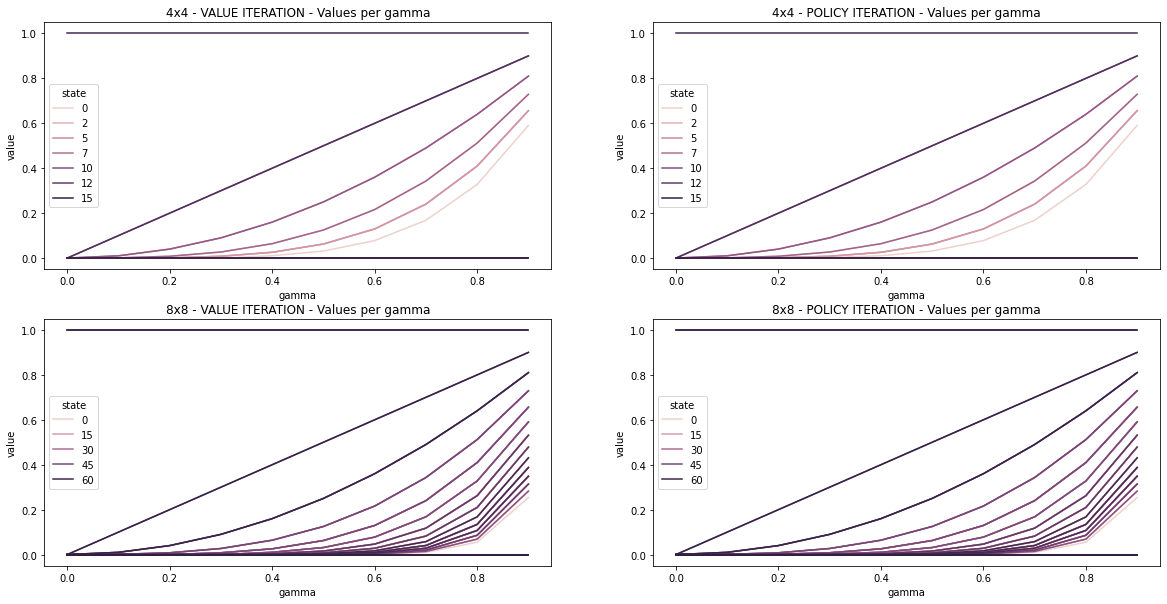

In [29]:
# function for performing value and policy iterations for given gamma
def gammas_training(method='value_iteration', 
                    gammas = np.arange(0, 1, 0.1),
                    env=gym.make('FrozenLake-v1', is_slippery=False)):
    df = pd.DataFrame(columns=['gamma','state','value'])
    for gamma in gammas:
        if method == 'value_iteration':
            V, P = compute_value_iteration(env=env, gamma=gamma, verbose=False)
        else:
            V, P = compute_policy_iteration(env=env, gamma=gamma, verbose=False)
        df = df.append(pd.DataFrame({'gamma':[gamma for i in range(0,env.observation_space.n)],
                                'state':[i for i in range(0,env.observation_space.n)],
                                'value': V}))
    df.state=df.state.astype(int)
    return df
    
    
# display the values for multiple gammas

fig, ax = plt.subplots(2,2, figsize=(20,10))

df_4_v = gammas_training(method='value_iteration', env=gym.make('FrozenLake-v1', is_slippery=False))
sns.lineplot(data=df_4_v, x='gamma', y='value', hue='state', ax=ax[0][0])
ax[0][0].set_title('4x4 - VALUE ITERATION - Values per gamma')

df_4_i = gammas_training(method='policy_iteration', env=gym.make('FrozenLake-v1', is_slippery=False))
sns.lineplot(data=df_4_i, x='gamma', y='value', hue='state', ax=ax[0][1])
ax[0][1].set_title('4x4 - POLICY ITERATION - Values per gamma')

df_8_v = gammas_training(method='value_iteration', env=gym.make('FrozenLake8x8-v1', is_slippery=False))
sns.lineplot(data=df_8_v, x='gamma', y='value', hue='state', ax=ax[1][0])
ax[1][0].set_title('8x8 - VALUE ITERATION - Values per gamma')

df_8_i = gammas_training(method='policy_iteration', env=gym.make('FrozenLake8x8-v1', is_slippery=False))
sns.lineplot(data=df_8_i, x='gamma', y='value', hue='state', ax=ax[1][1])
ax[1][1].set_title('8x8 - POLICY ITERATION - Values per gamma');